# Parallelization
## Install multi-threaded kernel
```julia
using IJulia
IJulia.installkernel("Julia 4 Threads", env=Dict(
    "JULIA_NUM_THREADS" => "4",
))
```
## Notes on Parallelization in Turing.jl 
`~` is only thread safe for observations not assumptions: https://github.com/TuringLang/Turing.jl/blob/master/HISTORY.md

This makes sampling from the prior a bit difficult, since we need to fill the observation with an assumption.
However, the following macro can be used to disable threading depending on a condition. Usage:
```julia
@maybethreads <condition> for ...
```


In [1]:
using Base.Threads
macro maybethreads(cond, ex)
    return esc(:($cond ? (@threads $ex) : $ex))
end

@maybethreads (macro with 1 method)

In [2]:
@maybethreads true for i in 1:10
    print(i)
end
Threads.nthreads()

12345678910

1

# Setup Environment

In [3]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using ModernGL, GLAbstraction, GLFW, SciGL
# TODO How to avoid adding them (automatically install / use with SciGL.jl)
using CoordinateTransformations, Rotations
using Images
using Turing, MCMCChains
using BenchmarkTools, StatsPlots
gr(size=(800,400))

  Activating environment at `~/code/w-kollo-mcmc-depth-images/Project.toml`
Precompiling project...
  ✓ TuringDepth
  1 dependency successfully precompiled in 3 seconds (313 already precompiled)


Plots.GRBackend()

# Initialize the **OpenGL** offscreen render context

In [4]:
const WIDTH = 200
const HEIGHT = 200
# Create the GLFW window. This sets all the hints and makes the context current.
window = context_offscreen(WIDTH, HEIGHT)
# Buffer
framebuffer = depth_framebuffer(WIDTH, HEIGHT)
enable_depth_stencil()
set_clear_color()
# Shader Program
depth_prog = GLAbstraction.Program(SimpleVert, DepthFrag);

Load the the camera and mesh. Wrap them in a scene for simplified rendering.

In [6]:
camera = CvCamera(WIDTH, HEIGHT, 1.2 * WIDTH, 1.2 * HEIGHT, WIDTH / 2, HEIGHT / 2) |> SceneObject
monkey = load_mesh(depth_prog, "meshes/monkey.obj") |> SceneObject
cube = load_mesh(depth_prog, "meshes/cube.obj") |> SceneObject
scene = Scene(camera, [monkey]);

In [7]:
function render_scene(scene::Scene)
    GLAbstraction.bind(framebuffer)
    clear_buffers()
    draw(depth_prog, scene)
    transpose(gpu_data(framebuffer, 1)[:,end:-1:1])
end;

For visualization: makes depth differences visible

In [8]:
function normalize_depth(img)
    img = img .- minimum(img)
    img = img ./ maximum(img)
end;

# Render the nominal scene

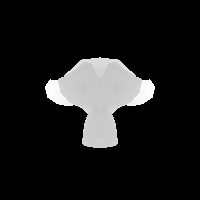

In [9]:
t = [0 0 2.]
r = [0 π 0]
monkey.pose.t = Translation(t)
monkey.pose.R = RotZYX(r...)
# cube.pose.t = Translation([0.5 0 2])
camera.pose.R = lookat(camera, monkey, [0 1 0]);
nominal_depth = render_scene(scene)
normalize_depth(nominal_depth)

# Probabilistic Model

Describes how the data is generated given:
- A `scene` with all relevant object, the first object is assumed to be the object of interest
- The RFID measurement for the position with the mean and covariance `mean_t` & `cov_t`
- The model will be conditioned on the depth image `y`

In [10]:
@model simple_depth(s, mean_t, y) = begin  
    # Sample position from RFID position
    t .~ Normal.(mean_t, 0.1)
    # We don't know anything about the orientation
    r ~ filldist(Uniform(-π, π), 3)
    # Render scene
    s.meshes[1].pose.t = Translation(t)
    s.meshes[1].pose.R = RotZYX(r...)
    μ = Float32.(render_scene(s))
    
    # Prior sampling -> y will be missing
    if y === missing
        y = Matrix{Float32}(undef, size(μ)...)
    end
    
    # Apply sensor noise
    y .~ Normal.(μ, 0.1)
end

simple_depth (generic function with 2 methods)

Generate one sample from the probabilistic model. Ideally, this should be representative for a measurement, we expect from the real world scene and sensor.

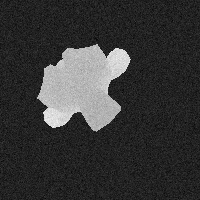

In [11]:
prior_sample = simple_depth(scene, t, missing)
prior_depth = prior_sample()
normalize_depth(Gray.(prior_depth))

# Inference

In [12]:
chain = sample(simple_depth(scene, t, prior_depth), MH(), 50000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:08


# Results

In [13]:
plot(chain)

# Extended Models

In [14]:
@model depth_model(μ, y) = begin
    # Prior sampling does not support threading and missing data has to be filled
    if y === missing
        enable_threading = false
        y = Matrix{Float32}(undef, size(μ)...)
    else
        enable_threading = true
    end
    # Fixed parameters
    θ = 1
    σ = 0.01
    # occlusion prior
    occlusion_prob ~ filldist(Uniform(), size(μ)...)
    occluded = Matrix{Bool}(undef, size(μ)...)
    occluded .~ Bernoulli.(occlusion_prob)
    # depth measurement model
    @maybethreads enable_threading for i in eachindex(μ)
        # Each pixel individually? Huge Memory requirement for many Chains
        # occlusion_prob[i] ~ Uniform()
        # occluded ~ Bernoulli(occlusion_prob[i])
        if occluded[i]
            y[i] ~ Exponential(θ)
        else
            y[i] ~ Normal(μ[i], σ)
        end
        # y[i] ~ MixtureModel([Normal(μ[i], σ), Exponential(θ)], [0.5, 0.5])
    end
    # TODO Random measurement, before or after occlusion?
    return y
end;

In [15]:
@model depth_model_broadcast(μ, y) = begin
    # Init for iteration, https://turing.ml/dev/docs/using-turing/guide
    if y === missing
        y = Matrix{Float32}(undef, size(μ)...)
    end
    occluded = Matrix{Bool}(undef, size(μ)...)
    # Fixed parameters
    θ = 1
    σ = 0.01
    # occlusion model
    occlusion_prob ~ filldist(Uniform(), size(μ)...)
    occluded .~ Bernoulli.(occlusion_prob)
    # depth pixel model
    y .~ ifelse.(occluded, Exponential(θ), Normal.(μ, σ))
    # TODO Random measurement, before or after occlusion?
    return y
end;

In [16]:
occlusion_prob = get(chain, :occlusion_prob);
#plot(chain[Symbol("occlusion_prob[50,50]")])

In [17]:
# Visualize the occlusion
mean_occlusion = Matrix{Float32}(undef, WIDTH, HEIGHT)
for i in eachindex(mean_occlusion)
    mean_occlusion[i] = mean(occlusion_prob.occlusion_prob[i].data)
end
Gray.(mean_occlusion)

LoadError: type NamedTuple has no field occlusion_prob

# Benchmark Broadcasting vs Loop

In [ ]:
@benchmark sample(depth_model(Float32.(nominal_depth), prior_depth), MH(), 10)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 23.919 s (11.32% GC) to evaluate,
 with a memory estimate of 121.03 GiB, over 35177398 allocations.

In [ ]:
@benchmark sample(depth_model_broadcast(Float32.(nominal_depth), prior_depth), MH(), 10)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 26.381 s (10.44% GC) to evaluate,
 with a memory estimate of 120.96 GiB, over 33187802 allocations.

# Conclusion
## Arrays in Turing
- MCMC chains takes forever to construct since every variable of an array gets its own symbol
- Multithreading is possible but not trivial, since only observations are threadsafe. When sampling from the prior, the observations become assumptions
## Broadcast vs Loop
- Broadcasting is less intuitive
- Broadcasting also seems slower